### CASE 1 Visualize the Experiment Result

In [3]:
from cornac.metrics_explainer.exp_experiment import Explainers_Experiment
from cornac.datasets.goodreads import prepare_data
from cornac.metrics_explainer import Metric_Exp_DIV as DIV, Metric_Exp_FPR as FPR, Metric_Exp_FA as FA, Metric_Exp_RA as RA
from cornac.models import EFM, MTER
from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.experiment import Visualization

rs_sent_dense = prepare_data(data_name="goodreads", test_size=0, dense=True, item=True, user=True, sample_size=1, seed=21)
fdiv = DIV()
fpr = FPR()
fpr_with_input_as_groundtruth = FPR(fpath="../cornac/datasets/good_reads/goodreads_sentiment_full.txt")
efm = EFM(max_iter=20, num_explicit_factors=50, num_latent_factors=50, num_most_cared_aspects=50, alpha=0.85,lambda_h=0.1, lambda_u=0.001, lambda_v=0.01, lambda_x=1.0, lambda_y= 0.1)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)
mter = MTER(max_iter=20, n_aspect_factors=8, n_item_factors=5, n_opinion_factors= 5, n_user_factors= 10, lambda_bpr=10, lambda_reg= 10, n_bpr_samples=1000, n_element_samples=50)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]
experiment = Explainers_Experiment(eval_method=rs_sent_dense, models=models, metrics=metrics,rec_k=10, feature_k=10, eval_train=True)
experiment.run()

/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Start training Recommender EFM...
*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
Step 1/3: Recommender EFM creates recommendations
Step 2/3: Explainer Exp_EFM create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 1569.34it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.612879546212961
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


Start evaluation... :  10%|█         | 900/9000 [00:02<00:24, 333.24it/s]


Result: Feature Precision: 0.3735119047619047; Feature Recall: 0.0200485855824297; Harmonic Mean: 0.03736795155796925
Start training Recommender MTER...
*****Start evaluating model-explainer: 'MTER:Exp_MTER'...
Step 1/3: Recommender MTER creates recommendations
Step 2/3: Explainer Exp_MTER create explanation for all recommendations


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 3637.86it/s]


Step 3/3: Metric Metric_Exp_DIV starts evaluation...
Result: Feature diversity: 0.11248181514856631
Step 3/3: Metric Metric_Exp_FPR starts evaluation...


/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/cornac-2.0.0-py3.9-macosx-11.1-arm64.egg/cornac/metrics_explainer/exp_experiment.py:183: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  (precision, recall, ff1), (precision_d, rec

Result: Feature Precision: 0.44062947067238917; Feature Recall: 0.2919102867561048; Harmonic Mean: 0.29804659555915153
experiment data: [[0.612879546212961, 0.03736795155796925, 0.07250189781188965, 5.989577054977417], [0.11248181514856631, 0.29804659555915153, 0.07754111289978027, 3.052281141281128]]


recommender:explainer |      Metric_Exp_DIV |      Metric_Exp_FPR |            Train(s) |       Evaluate(s)
EFM:Exp_EFM           |   0.612879546212961 | 0.03736795155796925 | 0.07250189781188965 | 5.989577054977417
MTER:Exp_MTER         | 0.11248181514856631 | 0.29804659555915153 | 0.07754111289978027 | 3.052281141281128



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Visualization(object):
    """Data Visualization class   """
    
    def __init__(self):
        """Initialize the Visualization class

        Args:
            
        """
        pass
                
    def visualize_experiemnt_result(self, EE, kind = "bar"):
        """Visualize the result of the runing experiment

        Args:
            EE (_class_): the class Object of the Explainers_Experiment
            kind (_string_): the type of the chart to be plotted, default is "bar", options: "bar", "line";
        """
        if EE.result is None:
            EE.run()
        # result = EE.data # list: the result of the experiment
        # pairs = EE.models # list: [model:explainer, model:explainer, ..]
        # metrics = EE.metrics # list: [metric1, metric2, .., train_cost, evaluate_cost]
        result = [list[1:] for list in EE.result]
        columns = [metric.name for metric in EE.metrics]
        columns.extend(["train_cost", "evaluate_cost"])
        pair_name_list = [list[0] for list in EE.result]
        data_df = pd.DataFrame(result, columns=columns, index=pair_name_list)
        data_df.fillna(0, inplace=True)
        metrics_data = data_df.iloc[:,:-2]
        cost_data = data_df.iloc[:,-2:]
        print("=======Start Visualization=======")
        if len(metrics_data.columns)>0:
            self._plot_exp_vs_metric(metrics_data, kind)
        if len(cost_data.columns)>0:
            self._plot_cost(cost_data)
        print("=======Visualization Done=======")
        
    def _plot_exp_vs_metric(self, df, kind = "bar"):
        """Plot the bar chart: compare the performance of model/explainer pairs on a specific metric

        Args:
            df (_dataframe_): a dataframe with the model/explainer pairs as rows and the metrics as columns
            kind (_string_): the type of the chart to be plotted, default is "bar", options: "bar", "line";
        """
        
        print(f"Plot the {kind} chart for the metrics:")
        if kind == "bar":
            plt.figure(figsize=(6, 4))
            df.plot(kind=kind, ax=plt.gca())
            plt.xticks(rotation=0)
            plt.show()
        print(df)
        if kind == "line":
            plt.figure(figsize=(6, 4))
            ax = df.plot(kind=kind, marker='o', linestyle='-')
            # Set x-axis labels to be the DataFrame index
            ax.set_xticks(range(len(df.index)))
            ax.set_xticklabels(df.index)
            plt.xticks(rotation=0)
            plt.show()
        
        # for column in df.columns:
        #     plt.bar(df.index, df[column], label=column)
        #     plt.ylabel(column)
        #     plt.show()

    def _plot_cost(self, df):
        """Plot the bar chart: compare the cost of training and evaluating the model/explainer pairs

        Args:
            df (_dataframe_): a dataframe with the model/explainer pairs as rows and the cost as columns
        """
        print("Plot the bar chart for the cost:")
        # Plotting the stacked bar chart
        # plt.bar(df.index, df.iloc[:, -2], label=df.columns[-2])
        # plt.bar(df.index, df.iloc[:, -1], bottom=df.iloc[:, -2], label=df.columns[-1])
        df.plot(kind='bar', stacked=True)
        # Adding labels and title
        plt.xticks(rotation=0)
        #plt.xlabel("model:explainer")
        plt.ylabel("time(s)")
        plt.legend()
        plt.show()


=======Start Visualization=======
Plot the bar chart for the metrics:


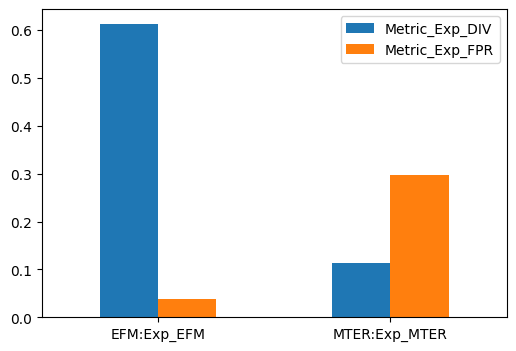

               Metric_Exp_DIV  Metric_Exp_FPR
EFM:Exp_EFM          0.612880        0.037368
MTER:Exp_MTER        0.112482        0.298047
Plot the bar chart for the cost:


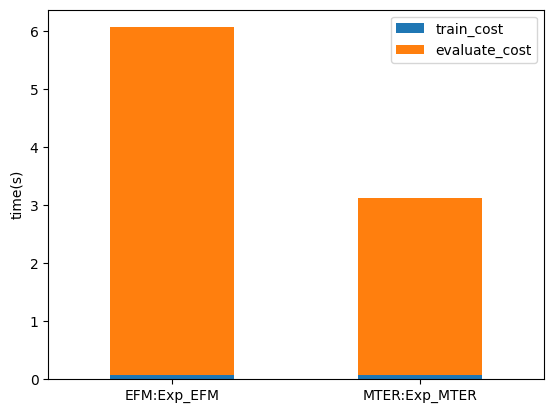

=======Visualization Done=======


In [7]:
vis = Visualization()
vis.visualize_experiemnt_result(experiment, kind="bar")

### CASE 2 Visualize the Effect of Parameters' Change (rec_k, feature_k)
Problem:
    - Explainaer_Experiment(models = [model_1, model_2], rec_k=10, feature_k = 10) fixed parameter for all models/explainers 
Solution:
    - Pass a list of Explainer_Experiment Object to func Visualization_Parameter_Change([EE_1, EE_2, EE_3], param_name = 'rec_k/feature_k')

### CASE 3 Visualize feature importance



In [1]:
import numpy as np
from cornac.models.fm_py import FMRec
from cornac.explainer.exp_limers import Exp_LIMERS
from cornac.datasets.goodreads import prepare_data
import warnings
warnings.filterwarnings('ignore')

rs = prepare_data(data_name="goodreads_limers", test_size=0.2, dense=True, item=True, user=False, sample_size=0.5, seed=21)
fm = FMRec()
fm.fit(train_set=rs.train_set)
explainer = Exp_LIMERS(fm, fm.train_set)
users = np.array(list(rs.train_set.uid_map.keys()))
items = np.array(list(rs.train_set.iid_map.keys()))
recommendations = fm.recommend_to_multiple_users(users)
explanations = explainer.explain_recommendations(recommendations)

/Users/yyz/miniconda3/envs/rose_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.91899
-- Epoch 2
Training MSE: 0.76278
-- Epoch 3
Training MSE: 0.73507
-- Epoch 4
Training MSE: 0.72087
-- Epoch 5
Training MSE: 0.70938
-- Epoch 6
Training MSE: 0.70206
-- Epoch 7
Training MSE: 0.69043
-- Epoch 8
Training MSE: 0.68147
-- Epoch 9
Training MSE: 0.67710
-- Epoch 10
Training MSE: 0.67173


Computing explanations: 100%|██████████| 10000/10000 [01:56<00:00, 85.63it/s]


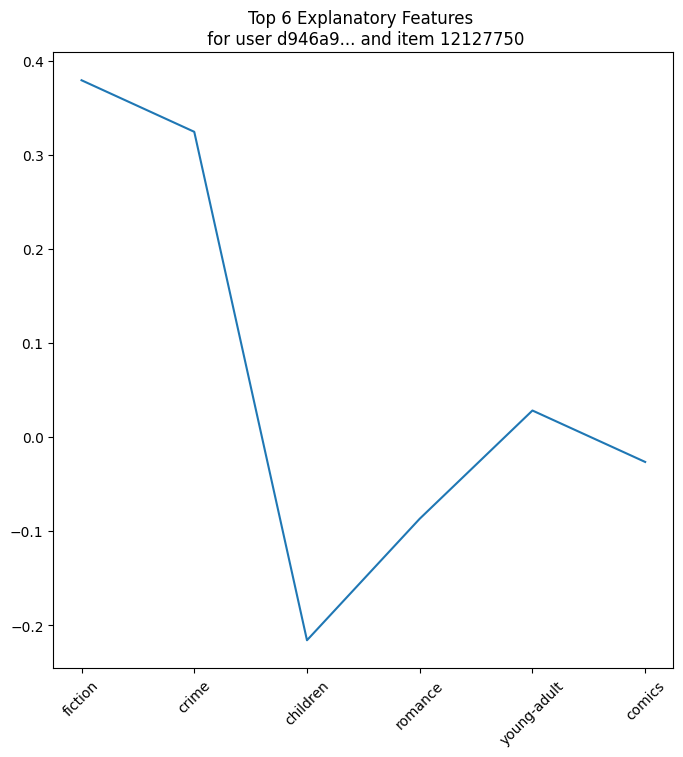

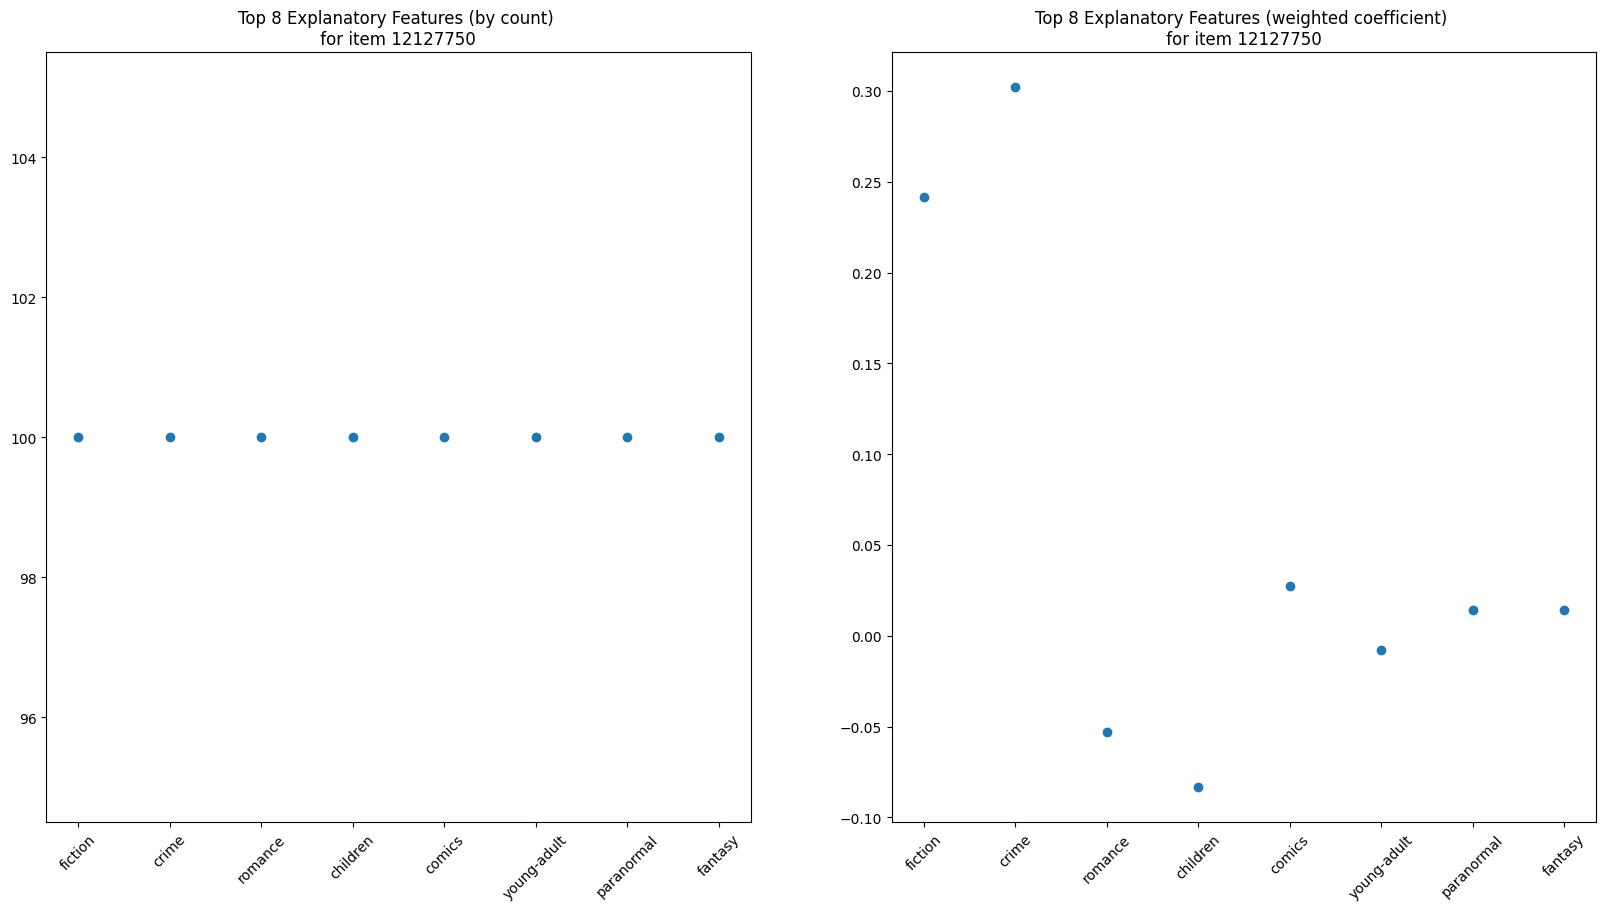

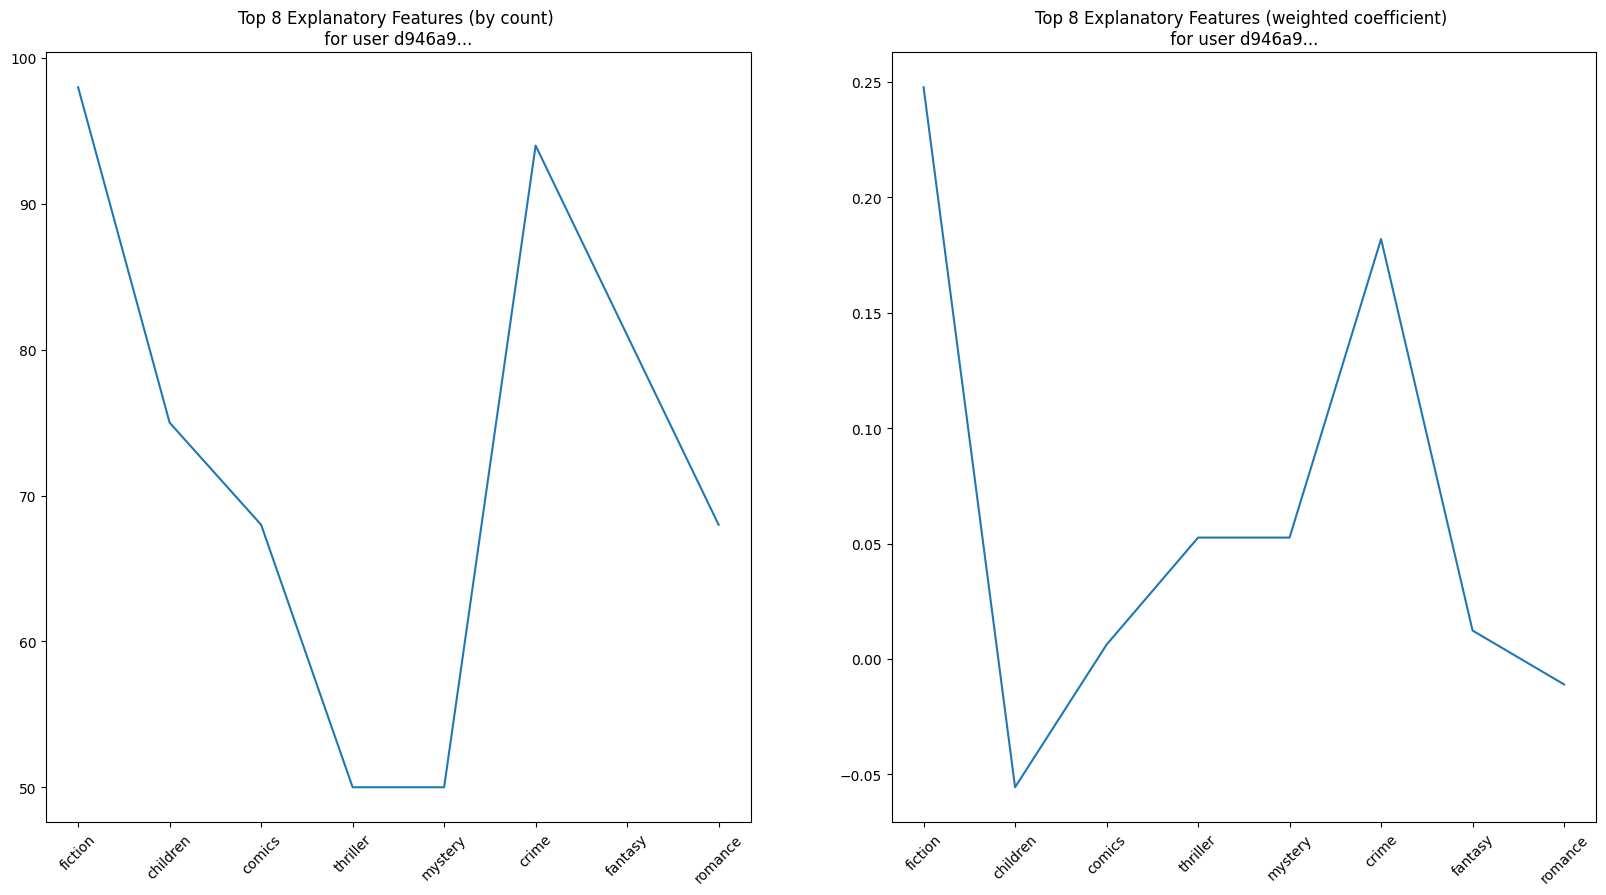

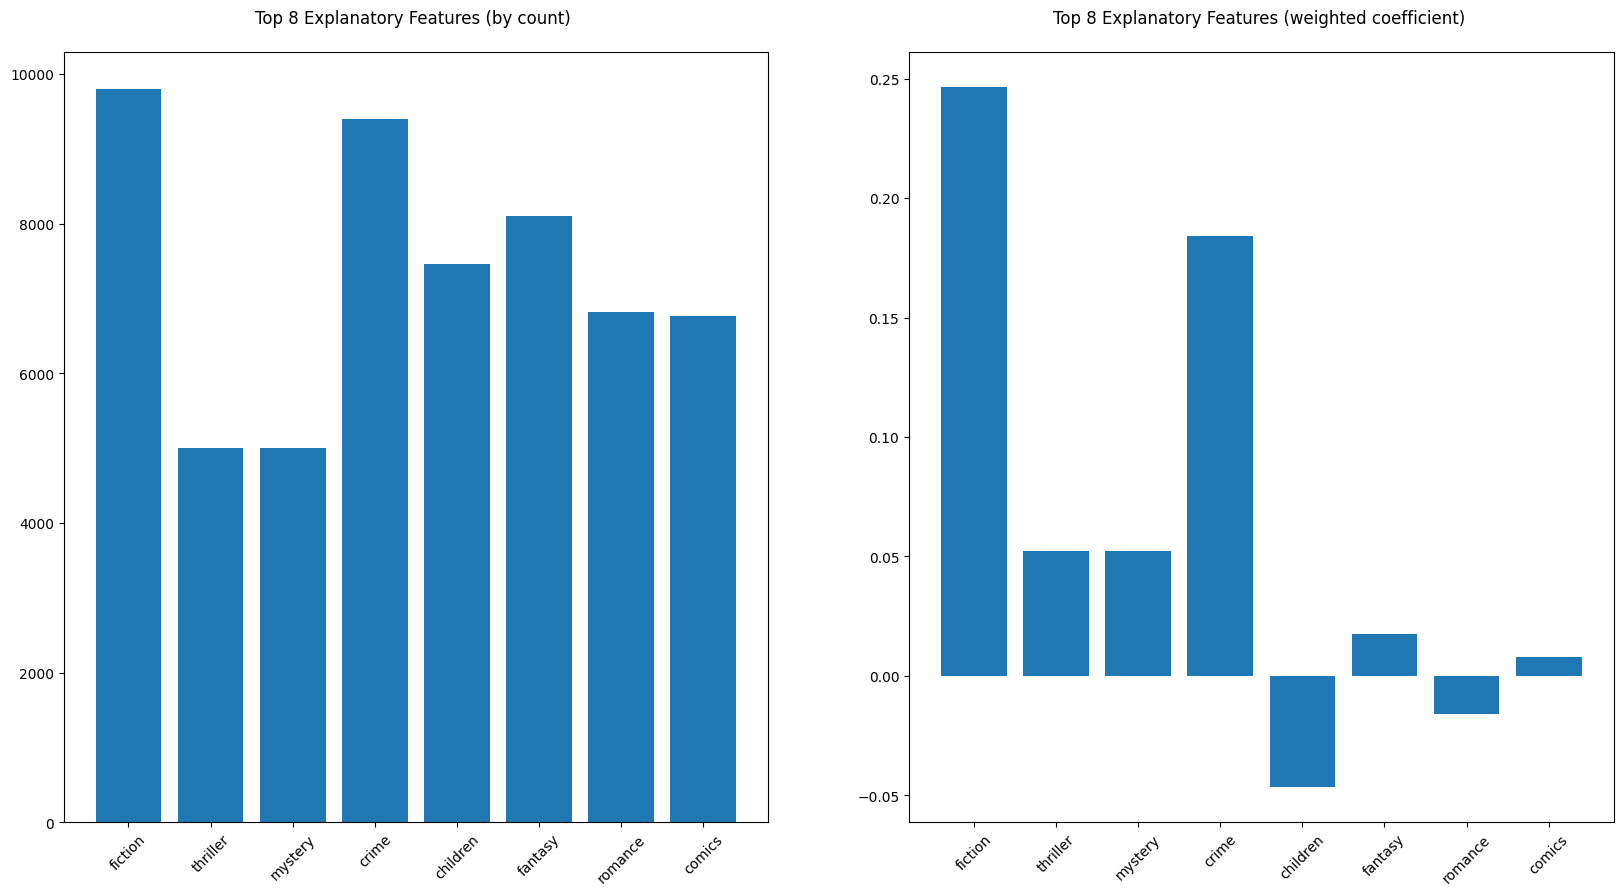

In [2]:
from cornac.experiment.visualization import Visualization

explanations_df = explanations.copy()
my_plots = Visualization()
ind_df = my_plots.create_individual_feature_importance_plot(explanations, user_id='d946a9aaa488924227a587c91564a484', item_id=12127750, type="line", top_k=6, save_plot=False)

filtered_df1 = my_plots.create_aggregate_feature_importance_plot(explanations, item_id=12127750, type="scatter", top_k=8, save_plot=False)

filtered_df2 = my_plots.create_aggregate_feature_importance_plot(explanations, user_id='d946a9aaa488924227a587c91564a484', type="line", top_k=8, save_plot=False)

filtered_df3 = my_plots.create_aggregate_feature_importance_plot(explanations, type="bar", top_k=8, save_plot=False)